# Numerical integration of double variable polynomials
This example uses the `integrate_2d` function to calculate
the integral
$$\int_{-1}^{1} P(x, y) \partial x \partial y$$
where $P_0(x)$ and $P_1(y)$ are polynomials.

For this example,
$$P_0(x) = L^2_i$$
$$P_1(y) = L^2_i$$

Where,

$L_i$, $i \in \{0 ... 7\}$, are the Lagrange polynomials created using $8$ Legendre-Gauss-Lobatto(LGL) points.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
import arrayfire as af
from matplotlib import pyplot as plt

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d

af.set_backend(params.backend)

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [10]:
N_LGL = 16
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)
Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)
Xi  = af.flat(Xi)
Eta = af.flat(Eta)

_, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

Li_xi  = af.np_to_af_array(Li_xi)
Lj_eta = af.np_to_af_array(Lj_eta)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [11]:
def function(x, y):
#     return af.sin(4 * ((x - 0.3)**2 + (y + 0.3)**2)) \
#          + af.cos(4 * ((x - 0.3)**2 + (y + 0.3)**2))
#     return af.sin(4 * ((x - 0.3)**2 + (y + 0.3)**2))
    return np.e**(-(x**2 + y**2) / 0.6**2)
#     return np.e**(-(0.5 * x**2 + 2. * y**2) / 0.6**2)
#     return af.sin(((x - 0.3)**2 + (y + 0.3)**2)) ** 4
#     return (af.sin((x**2 + y**2)) * af.cos((x**2 + y**2)))**4
#     return np.e**(-(x + y) / 0.6**2)

In [12]:
# print(Lq_eta)
Li_xi_tp = af.reorder(Li_xi, d0 = 2, d1 = 0, d2 = 1)
Li_xi_tp = af.tile(Li_xi_tp, d0 = N_LGL)
Li_xi_tp = af.moddims(Li_xi_tp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Li_xi_tp = af.reorder(Li_xi_tp, d0 = 0, d1 = 2, d2 = 1)

Lj_eta_tp = af.reorder(Lj_eta, d0 = 0, d1 = 2, d2 = 1)
Lj_eta_tp = af.tile(Lj_eta_tp, d0 = N_LGL)
Lj_eta_tp = af.reorder(Lj_eta_tp, d0 = 0, d1 = 2, d2 = 1)

In [13]:
function_ij = function(Xi, Eta)
function_interpol = w2d.lag_interpolation_2d(function_ij, N_LGL)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [14]:
error = []
ref_integral = 1.08968731296967

for n_quad in np.arange(3, 24):
    n_quad = int(n_quad)
    integral = utils.integrate_2d_multivar_poly(function_interpol, N_quad = n_quad, scheme = 'gauss')
    error.append(abs(integral - ref_integral))

error = np.array(error)

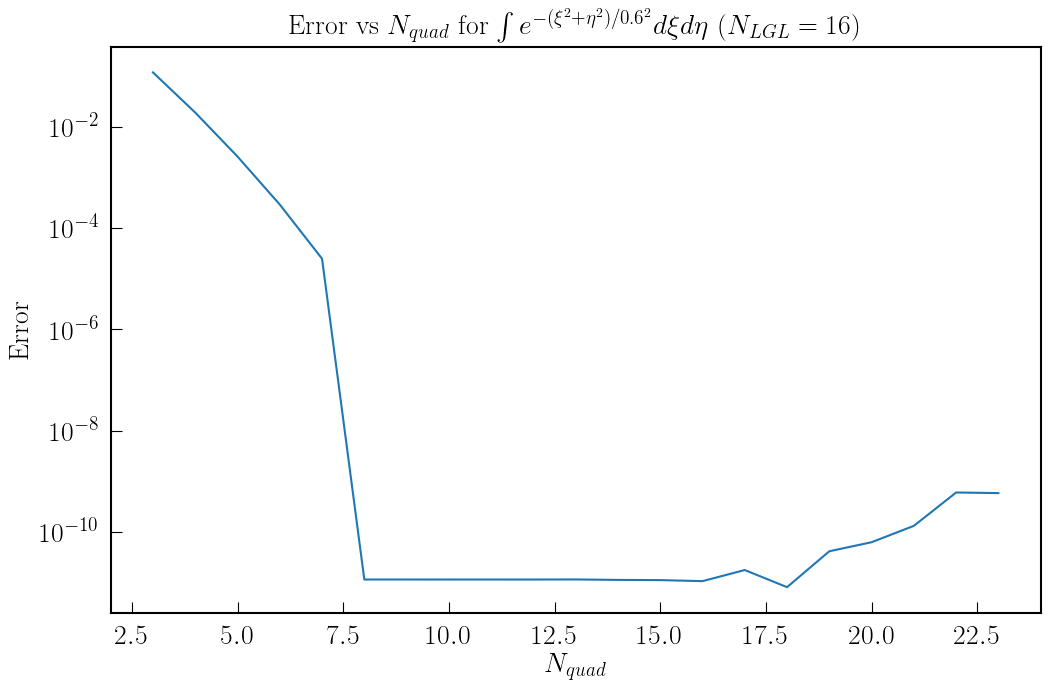

In [15]:
plt.title(r'Error vs $N_{quad}$ for $\int e^{-(\xi^2 + \eta^2) / 0.6^2} d\xi d\eta$ ($N_{LGL} = 16$)')
plt.xlabel(r'$N_{quad}$')
plt.ylabel(r'Error')
plt.semilogy(np.arange(3, 24, dtype = np.int), error)

plt.savefig('integrate_2d.png')
plt.show()

In [28]:
test_xi  = utils.linspace(-1, 1, 100)
test_eta = utils.linspace(-1, 1, 100)

test_Xi_mesh, test_Eta_mesh = utils.af_meshgrid(test_xi, test_eta)
test_Xi  = af.flat(test_Xi_mesh)
test_Eta = af.flat(test_Eta_mesh)

function_val = af.moddims(utils.polyval_2d(function_interpol, test_Xi, test_Eta), d0 = test_Xi_mesh.shape[0], d1 = test_Xi_mesh.shape[1])

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


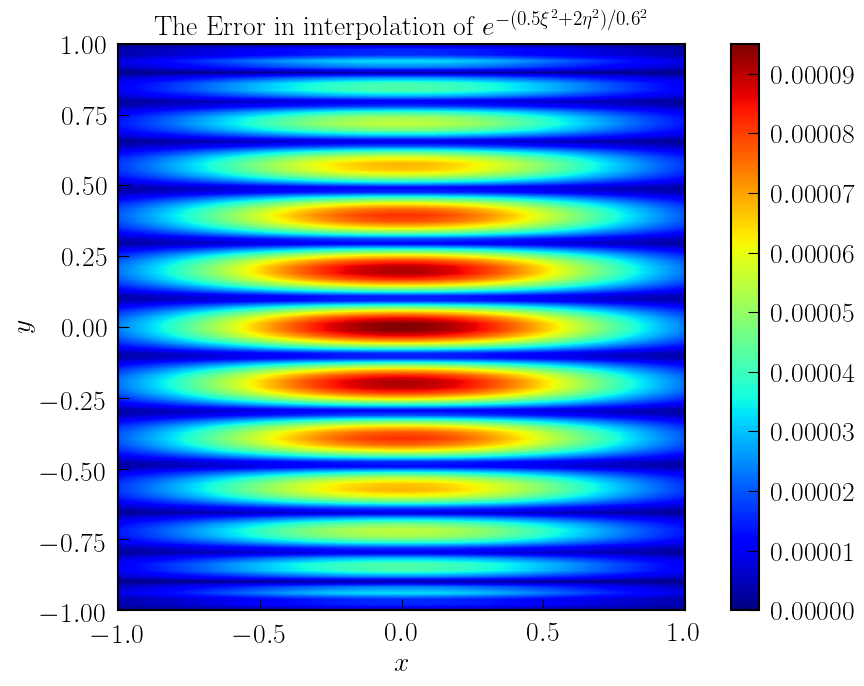

In [30]:
plt.contourf(np.array(test_Xi_mesh), np.array(test_Eta_mesh), np.array(af.abs(function_val - function(test_Xi_mesh, test_Eta_mesh))),
             200, cmap = 'jet')

plt.title(r'The Error in interpolation of $e^{-(0.5 \xi^2 + 2 \eta^2) / 0.6^2}$')
plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

plt.savefig('u_init.png')
plt.show()

In [22]:
# Example function usage

integral= utils.integrate_2d_multivar_poly(P_xi_eta, N_quad = 11, scheme = 'lobatto')
print(integral)

print(abs(integral - ref_integral))

16.00000000000336
3.360867140145274e-12


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [20]:
ref_integral = 1.08968731296967
error = []

for n_quad in np.arange(3, 24):
    N_LGL = 16
    xi_LGL  = lagrange.LGL_points(N_LGL)
    eta_LGL = lagrange.LGL_points(N_LGL)
    Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)
    Xi  = af.flat(Xi)
    Eta = af.flat(Eta)

    _, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
    _, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

    Li_xi  = af.np_to_af_array(Li_xi)
    Lj_eta = af.np_to_af_array(Lj_eta)

    # print(Lq_eta)
    Li_xi_tp = af.reorder(Li_xi, d0 = 2, d1 = 0, d2 = 1)
    Li_xi_tp = af.tile(Li_xi_tp, d0 = N_LGL)
    Li_xi_tp = af.moddims(Li_xi_tp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
    Li_xi_tp = af.reorder(Li_xi_tp, d0 = 0, d1 = 2, d2 = 1)

    Lj_eta_tp = af.reorder(Lj_eta, d0 = 0, d1 = 2, d2 = 1)
    Lj_eta_tp = af.tile(Lj_eta_tp, d0 = N_LGL)
    Lj_eta_tp = af.reorder(Lj_eta_tp, d0 = 0, d1 = 2, d2 = 1)

    Li_Lj_tp = utils.polynomial_product_coeffs(af.reorder(af.transpose(Li_xi_tp), 0, 2, 1),
                                               af.reorder(af.transpose(Lj_eta_tp), 0, 2, 1))


    function_ij = function(Xi, Eta)
    function_interpol = w2d.lag_interpolation_2d(function_ij, N_LGL)

    integral = utils.integrate_2d_multivar_poly(function_interpol, N_quad = n_quad, scheme = 'gauss')
    error.append(abs(integral - ref_integral))

error = np.array(error)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


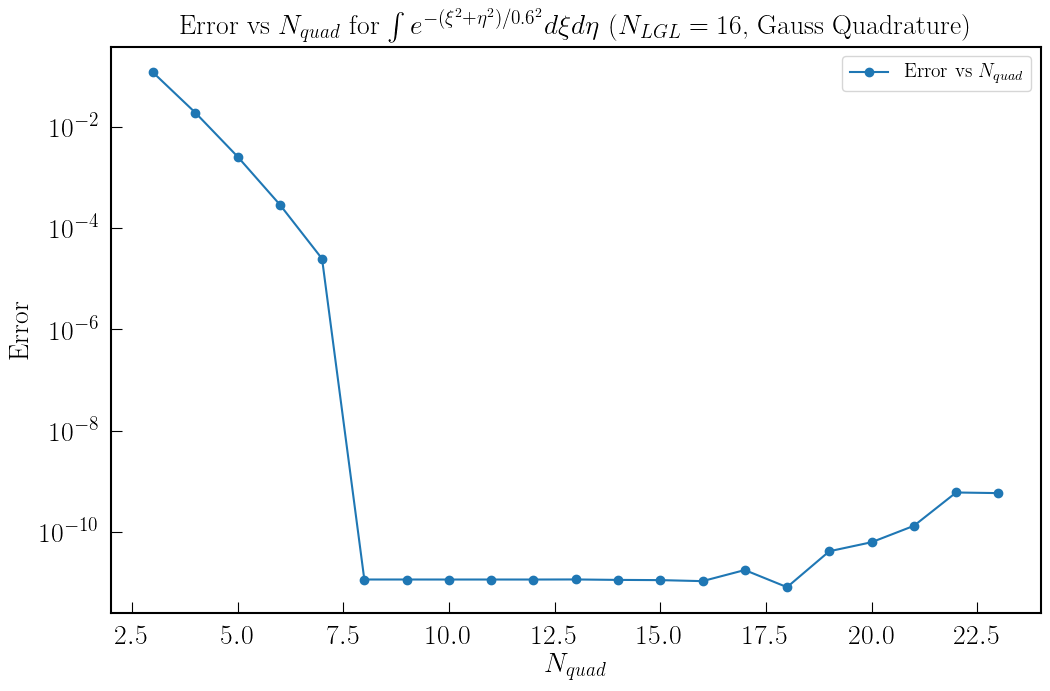

In [25]:
N_quad = np.arange(3, 24, dtype = np.float64)
plt.title(r'Error vs $N_{quad}$ for $\int e^{-(\xi^2 + \eta^2) / 0.6^2} d\xi d\eta$ ($N_{LGL} = 16$, Gauss Quadrature)')
plt.xlabel(r'$N_{quad}$')
plt.ylabel(r'Error')
plt.semilogy(N_quad, error, 'o-', label = r'Error vs $N_{quad}$')
# plt.semilogy(N_LGL[:11], 10 * (N_LGL[:11])**(-N_LGL[:11] * 0.76), '--', label = r'$N_{LGL}^{-N_{LGL}}$')
# plt.axes().set_aspect('equal')
plt.legend(prop={'size': 14})
# plt.ylim(np.min(error), np.max(error) + 0.1)
plt.savefig('integrate_2d.png')
plt.show()